# CNN Baseline model

This notebook aims to provide a baseline CNN model for comparison with our auto-supervised approach to the deepfake audio detection.

The model choosed was [YAMNet](https://www.kaggle.com/models/google/yamnet). It is a CNN based audio model pretrained on the [AudioSet](http://research.google.com/audioset/index.html) dataset, to classify between 521 audio event classes in a collection of 2,084,320 human-labeled 10-second sound clips drawn from YouTube videos. The architecture of YAMNet uses MobileNet v1.

The model was pretrained on a supervised way, and will be fine-tuned also in a supervised way, to see how it compares with the self-supervised approach.

To get the model, it is need to install **torch_vggish_yamnet** package: https://pypi.org/project/torch-vggish-yamnet/

## Summary

* [Part 1: Notebook setup](#part_01)
* [Part 2: Data loading](#part_02)
* [Part 3: Model fine tuning](#part_03)
* [Part 4: Model evaluation](#part_04)

## Notebook setup <a class="anchor" id="part_01"></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
from torch.nn import functional as TF
import torchaudio
import torchaudio.functional as TAF
import pathlib

from torch_vggish_yamnet import yamnet
from torch_vggish_yamnet.input_proc import *

PATH_TO_DATASET = "/media/elias/ssd1tb/Projects/AUDIOS/datasets/release"

RANDOM_STATE = 7 # the biblical number of perfection =)

BATCH_SIZE = 128

model = yamnet.yamnet(pretrained=True)
converter = WaveformToInput()

print(
    "number of params:",
    sum(param.numel() for param in model.parameters() if param.requires_grad),
)

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

if "cuda" in str(device):
    model = model.to(device)

# params: 3740425


## Data loading  <a class="anchor" id="part_02"></a>

In [2]:
train_metadata_df = pd.read_csv(os.path.join(PATH_TO_DATASET, 'splits', 'by_file', "files-downstream_train.csv"))
train_metadata_df.head()

,file,speaker,id,gender,label
0,fake_voices/Alcione_F018_Fake/1000_fake.wav,Alcione,F018,F,spoof
1,fake_voices/Alcione_F018_Fake/100_fake.wav,Alcione,F018,F,spoof
2,fake_voices/Alcione_F018_Fake/101_fake.wav,Alcione,F018,F,spoof
3,fake_voices/Alcione_F018_Fake/102_fake.wav,Alcione,F018,F,spoof
4,fake_voices/Alcione_F018_Fake/103_fake.wav,Alcione,F018,F,spoof


In [3]:
validation_metadata_df = pd.read_csv(os.path.join(PATH_TO_DATASET, 'splits', 'by_file', "files-downstream_val.csv"))
validation_metadata_df.head()

,file,speaker,id,gender,label
0,fake_voices/Aurea_F036_Fake/1000_fake.wav,Aurea,F036,F,spoof
1,fake_voices/Aurea_F036_Fake/100_fake.wav,Aurea,F036,F,spoof
2,fake_voices/Aurea_F036_Fake/101_fake.wav,Aurea,F036,F,spoof
3,fake_voices/Aurea_F036_Fake/102_fake.wav,Aurea,F036,F,spoof
4,fake_voices/Aurea_F036_Fake/103_fake.wav,Aurea,F036,F,spoof


### Dataset and dataloader

In [ ]:
from torch.utils.data import Dataset
from tqdm import tqdm

class AudioDataset(Dataset):
    """Dataset class from pytorch
    
    Cache dataset indicates if we want to load the entire dataset preprocessed
    on RAM (only works if 32GB memory or higher)"""
    def __init__(self, metadata_df: pd.DataFrame, audio_dir: str, cache_dataset = False):
        self.metadata_df = metadata_df
        self.audio_dir = audio_dir
        
        self.metadata_df['label_encoded'] = self.metadata_df['label'].map({
            "bona-fide": 0,
            "spoof": 1
        })
        
        self._converter = WaveformToInput()
        
        self.cache_dataset = cache_dataset
        
        if cache_dataset:
            self.load_all_audios()
            
            
    def load_all_audios(self):
        """Load and preprocess all audios from the memory"""
        self.audios_cache = []

        for filename in tqdm(self.metadata_df['file'], desc="Loading audio files"):
            audio_path = os.path.join(self.audio_dir, filename)
            self.audios_cache.append(self.load_and_preprocess_audio(audio_path))

    def __len__(self):
        return len(self.metadata_df)
    
    def __getitem__(self, idx):
        if self.cache_dataset:
            return self.audios_cache[idx], self.metadata_df.iloc[idx]['label_encoded']
        
        # if not cache, load the individual file
        row = self.metadata_df.iloc[idx]
        # Load audio file
        audio_path = os.path.join(self.audio_dir, row['file'])
        
        return self.load_and_preprocess_audio(audio_path), row['label_encoded']
    
    
    def load_and_preprocess_audio(self, path_to_audio):
        """Load an audio of the memory and preprocess it to be adequate to YAMNet model,
        converting it into a mel spectogram"""
        waveform, sample_rate = torchaudio.load(path_to_audio)
        
        in_tensor = converter(waveform.float().to('cpu'), sample_rate=sample_rate)
    
        # we only use the first mel spectogram
        return in_tensor[0].unsqueeze(0)
    
dataset_train = AudioDataset(train_metadata_df, PATH_TO_DATASET, cache_dataset=False)
dataset_val = AudioDataset(validation_metadata_df, PATH_TO_DATASET, cache_dataset=False)

print("Sucess creating datasets")

## Model fine-tuning  <a class="anchor" id="part_03"></a>

### Making a simple prediction

In [20]:
# testing in a sample audio
sample_audio = train_metadata_df.file.iloc[0]
audio_path = os.path.join(PATH_TO_DATASET, sample_audio)

waveform = dataset_train.load_and_preprocess_audio(audio_path)
waveform.shape

torch.Size([1, 1, 96, 64])

In [ ]:
# making a output with the model
waveform = waveform.unsqueeze(0).to(device)

with torch.no_grad():
    model.eval()
    output, logits = model(waveform)

print(output)
print(logits)

print("Output shape", output.shape, ", Logits shape:", logits.shape)

tensor([[[[0.1994]],

         [[0.8764]],

         [[0.0014]],

         ...,

         [[0.0000]],

         [[0.0634]],

         [[0.0000]]]], device='cuda:0')
tensor([[  5.6084, -11.2223,  -4.5911,  -2.5769, -30.5669,  -5.5606, -15.2858,
         -23.5190, -17.8143, -24.3510, -36.1819, -26.9622, -23.9877, -16.4120,
         -37.3396, -31.2471, -25.3460, -35.4965, -19.0958, -20.6494, -25.0385,
         -23.4274, -33.2942, -24.7194, -10.1944, -17.1616, -27.7706, -10.6117,
         -10.6751, -17.6233, -25.9971, -13.2971, -23.7731, -21.5035, -28.3427,
         -21.6181, -18.8132, -37.4282, -22.5331, -26.4204, -36.8559, -32.1319,
         -33.0455, -34.8265, -31.2550, -43.8097, -17.8145, -40.8623, -25.8328,
         -38.9744, -39.7136, -27.7235, -28.3599, -24.4264, -35.4766, -29.8792,
         -27.5832, -32.9911, -31.7779, -23.9280, -28.8766, -24.5684, -22.4332,
         -22.9865, -16.6482, -27.8043, -38.4387, -14.7434, -17.7256, -18.9805,
         -26.2700, -24.6760, -29.7443, -24.36

### Model architecture adaptation

Our adaptation is going to be simple: just change from 521 classes of the original AudioSet dataset to one node, predicting the bonafide probability

In [11]:
model

YAMNet(
  (layer1): Conv(
    (fused): CONV_BN_RELU(
      (conv): Conv2d_tf(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=SAME, bias=False)
      (bn): BatchNorm2d(32, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
  )
  (layer2): SeparableConv(
    (depthwise_conv): CONV_BN_RELU(
      (conv): Conv2d_tf(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=SAME, groups=32, bias=False)
      (bn): BatchNorm2d(32, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pointwise_conv): CONV_BN_RELU(
      (conv): Conv2d_tf(32, 64, kernel_size=(1, 1), stride=(1, 1), padding=SAME, bias=False)
      (bn): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
  )
  (layer3): SeparableConv(
    (depthwise_conv): CONV_BN_RELU(
      (conv): Conv2d_tf(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=SAME, groups=64, bias=False)
      (bn): BatchNorm2d(

In [ ]:
# changing the output layer to two classes
from torch import nn
from torchinfo import summary

model.classifier = nn.Linear(in_features=1024, out_features=1)
summary(model, input_size=[1, 1, 96, 64])

### Model training
Let's fine tune our model with the training data, using 10 epochs and a small learning rate.

All the weights are trained here (there are no layers frozen)

In [14]:
from sklearn.metrics import roc_curve


def compute_eer(y_true, y_scores):
    """
    Compute the Equal Error Rate (EER) given true labels and prediction scores.
    
    Args:
        y_true (numpy.ndarray): Ground truth binary labels (0 or 1).
        y_scores (numpy.ndarray): Predicted scores (logits or probabilities).

    Returns:
        eer (float): The Equal Error Rate.
        threshold (float): The threshold at which EER is achieved.
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    fnr = 1 - tpr  # False negative rate is 1 - true positive rate
    eer_threshold = thresholds[np.nanargmin(np.abs(fnr - fpr))]
    eer = fpr[np.nanargmin(np.abs(fnr - fpr))]
    return eer, eer_threshold

Epoch [1/10] | Train Loss: 0.0181 | Val Loss: 0.0400 | Val Accuracy: 0.9869 | EER: 0.0070


Epoch [2/10] | Train Loss: 0.0039 | Val Loss: 0.0057 | Val Accuracy: 0.9986 | EER: 0.0015


Epoch [3/10] | Train Loss: 0.0020 | Val Loss: 0.0234 | Val Accuracy: 0.9946 | EER: 0.0047


Epoch [4/10] | Train Loss: 0.0027 | Val Loss: 0.0111 | Val Accuracy: 0.9969 | EER: 0.0027


Epoch [5/10] | Train Loss: 0.0015 | Val Loss: 0.0239 | Val Accuracy: 0.9939 | EER: 0.0011


Epoch [6/10] | Train Loss: 0.0017 | Val Loss: 0.0177 | Val Accuracy: 0.9922 | EER: 0.0053


Epoch [7/10] | Train Loss: 0.0020 | Val Loss: 0.0023 | Val Accuracy: 0.9989 | EER: 0.0010


Epoch [8/10] | Train Loss: 0.0000 | Val Loss: 0.0024 | Val Accuracy: 0.9993 | EER: 0.0008


Epoch [9/10] | Train Loss: 0.0000 | Val Loss: 0.0085 | Val Accuracy: 0.9979 | EER: 0.0008


Epoch [10/10] | Train Loss: 0.0000 | Val Loss: 0.0072 | Val Accuracy: 0.9984 | EER: 0.0010


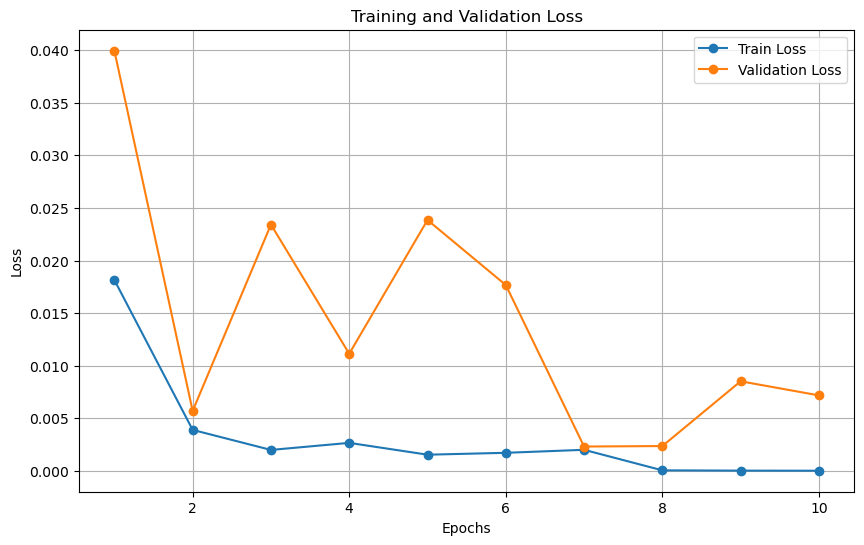

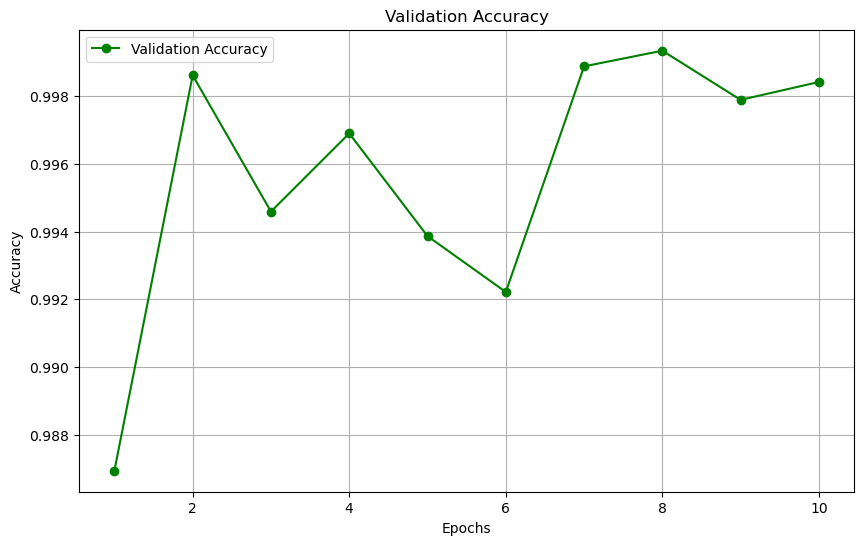

Training complete.


In [ ]:
# Adapted from src/train/mlp/train_mlp.py

import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# Hyperparameters
num_epochs = 10
learning_rate = 3e-4
batch_size = BATCH_SIZE
patience = 10
save_dir = "/media/elias/ssd1tb/Projects/AUDIOS/models/model_checkpoints"  # Directory to save models
os.makedirs(save_dir, exist_ok=True)

train_dataloader = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=False)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

history = {
    "epoch": [],
    "train_loss": [],
    "val_loss": []
}

# Training loop
train_losses, val_losses, val_accuracies, val_eers = [], [], [], []
best_val_loss = float("inf")
best_val_eer = float("inf")
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
        inputs, labels = batch[0].to(device), batch[1].float().to(device)
        optimizer.zero_grad()
        outputs = model(inputs.squeeze(1))
        train_loss = criterion(outputs[1].squeeze(1), labels)
        train_loss.backward()
        optimizer.step()
        running_train_loss += train_loss.item()

    avg_train_loss = running_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    running_val_loss = 0.0
    all_targets = []
    all_scores = []
    with torch.no_grad():
        for batch in val_dataloader:
            inputs, labels = batch[0].to(device), batch[1].float().to(device)
            outputs = model(inputs.squeeze(1))
            val_loss = criterion(outputs[1].squeeze(1), labels)
            running_val_loss += val_loss.item()

            # Accuracy calculation
            predictions = (torch.sigmoid(outputs[1].squeeze(1)) >= 0.5).int()
            correct_predictions += (predictions == labels.int()).sum().item()
            total_samples += labels.size(0)

            # Store true labels and scores for EER computation
            all_targets.extend(labels.cpu().numpy())
            all_scores.extend(outputs[1].squeeze(1).cpu().numpy())

    avg_val_loss = running_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    # Compute validation accuracy
    val_accuracy = correct_predictions / total_samples
    val_accuracies.append(val_accuracy)

    # Compute EER (if required)
    eer, eer_threshold = compute_eer(np.array(all_targets), np.array(all_scores))
    val_eers.append(eer)

    if eer < best_val_eer:
        best_val_eer = eer

    # Save best model based on validation loss
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), os.path.join(save_dir, "best_model.pth"))
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    # Log results for the current epoch
    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
          f"Val Accuracy: {val_accuracy:.4f} | EER: {eer:.4f}")

# Save history
history = {
    "train_losses": train_losses,
    "val_losses": val_losses,
    "val_accuracies": val_accuracies,
    "val_eers": val_eers,
}
np.save(os.path.join(save_dir, "training_history.npy"), history)

# Plot loss and accuracy curves (optional)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss", marker="o")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", marker="o")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(save_dir, "loss_plot.png"))
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Validation Accuracy", marker="o", color="green")
plt.title("Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(save_dir, "accuracy_plot.png"))
plt.show()

print("Training complete.")



## Model evaluation <a class="anchor" id="part_04"></a>

Let's evaluate the model acording to the metrics defined on our planning

In [ ]:
def make_predictions(model, metadata_df):
    """Make the predictions on the given files on metainfo_df
    
    Return a dataframe with the values of the predictions"""
    output_list = []
    dataloader = DataLoader(dataset=AudioDataset(metadata_df, PATH_TO_DATASET), batch_size=BATCH_SIZE)

    with torch.no_grad():
        model.eval()
        for batch in tqdm(dataloader, desc=f"Inference", leave=False):
            inputs = batch[0]  # (batch_size, channels, length)
            labels = batch[1].float()  # Convert labels to float for BCE loss

            # Move tensors to GPU if available
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs.squeeze(1))

            output_list.append(torch.sigmoid(outputs[1]).to('cpu').numpy())
            
    sig = nn.Sigmoid()
    metadata_df['predict_proba'] = np.concatenate(output_list)
    metadata_df['prediction'] = metadata_df['predict_proba'].round().astype(int)
    
    return metadata_df

train_metadata_df_results = make_predictions(model, train_metadata_df)
train_metadata_df_results['train'] = True

val_metadata_df_results = make_predictions(model, validation_metadata_df)
val_metadata_df_results['train'] = False

results_df = pd.concat([train_metadata_df_results, val_metadata_df_results], axis='rows')
results_df = results_df.reset_index(drop=True)

# standarized way to see the results
results_df.head()

,file,speaker,id,gender,label,label_encoded,predict_proba,prediction,train
0,fake_voices/Alcione_F018_Fake/1000_fake.wav,Alcione,F018,F,spoof,1,0.999995,1,True
1,fake_voices/Alcione_F018_Fake/100_fake.wav,Alcione,F018,F,spoof,1,0.999995,1,True
2,fake_voices/Alcione_F018_Fake/101_fake.wav,Alcione,F018,F,spoof,1,0.999995,1,True
3,fake_voices/Alcione_F018_Fake/102_fake.wav,Alcione,F018,F,spoof,1,0.999995,1,True
4,fake_voices/Alcione_F018_Fake/103_fake.wav,Alcione,F018,F,spoof,1,0.999994,1,True


### Metrics

In [21]:
from sklearn.metrics import roc_curve
# Split data based on 'train' column
train_results = results_df[results_df['train'] == True]
non_train_results = results_df[results_df['train'] == False]

# Function to calculate TP, FP, FN, TN, Precision, Recall, Accuracy, and F1 Score
def calculate_metrics(df):
    TP = ((df['label_encoded'] == 1) & (df['prediction'] == 1)).sum()
    FP = ((df['label_encoded'] == 0) & (df['prediction'] == 1)).sum()
    FN = ((df['label_encoded'] == 1) & (df['prediction'] == 0)).sum()
    TN = ((df['label_encoded'] == 0) & (df['prediction'] == 0)).sum()

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    accuracy = (TP + TN) / (TP + FP + FN + TN) if (TP + FP + FN + TN) > 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return precision, recall, accuracy, f1_score

# Function to calculate EER
def calculate_EER(df):
    y_true = df['label_encoded']
    y_pred = df['predict_proba']
    fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)
    fnr = 1 - tpr
    eer = fpr[np.nanargmin(np.absolute(fnr - fpr))]
    return eer

# Calculate metrics for training entries
train_precision, train_recall, train_accuracy, train_f1_score = calculate_metrics(train_results)
train_eer = calculate_EER(train_results)

# Calculate metrics for non-training (validation) entries
val_precision, val_recall, val_accuracy, val_f1_score = calculate_metrics(non_train_results)
val_eer = calculate_EER(non_train_results)

# Print metrics for training entries
print(f"Train -")
print(f"  Precision: {train_precision:.4f}")
print(f"  Recall: {train_recall:.4f}")
print(f"  Accuracy: {train_accuracy:.4f}")
print(f"  F1 Score: {train_f1_score:.4f}")
print(f"  EER: {train_eer:.4f}")
print()

# Print metrics for validation entries
print(f"Validation -")
print(f"  Precision: {val_precision:.4f}")
print(f"  Recall: {val_recall:.4f}")
print(f"  Accuracy: {val_accuracy:.4f}")
print(f"  F1 Score: {val_f1_score:.4f}")
print(f"  EER: {val_eer:.4f}")


Train -
  Precision: 1.0000
  Recall: 1.0000
  Accuracy: 1.0000
  F1 Score: 1.0000
  EER: 0.0000

Validation -
  Precision: 0.9967
  Recall: 1.0000
  Accuracy: 0.9984
  F1 Score: 0.9983
  EER: 0.0010


### Confusion matrices

In [22]:
# Function to create and print confusion matrix
def print_confusion_matrix(df, set_name):
    TP = ((df['label_encoded'] == 1) & (df['prediction'] == 1)).sum()
    FP = ((df['label_encoded'] == 0) & (df['prediction'] == 1)).sum()
    FN = ((df['label_encoded'] == 1) & (df['prediction'] == 0)).sum()
    TN = ((df['label_encoded'] == 0) & (df['prediction'] == 0)).sum()

    print(f"{set_name} Confusion Matrix:")
    print(f"          Predicted 0    Predicted 1")
    print(f"Actual 0    {TN:10}    {FP:10}")
    print(f"Actual 1    {FN:10}    {TP:10}\n")

# Print confusion matrix for training and validation sets
print_confusion_matrix(train_results, "Train")
print_confusion_matrix(non_train_results, "Validation")

Train Confusion Matrix:
          Predicted 0    Predicted 1
Actual 0         24998             0
Actual 1             0         21395

Validation Confusion Matrix:
          Predicted 0    Predicted 1
Actual 0          7976            24
Actual 1             0          7160



### Saving the model

In [19]:
torch.save(model.state_dict(), '/media/elias/ssd1tb/Projects/AUDIOS/models/baseline_model_state_dict.pth')